# Warsztaty modelowania w nanofizyce
----
## Zachowania atomów w zależności od ich rodzaju i położenia

**Paweł T. Jochym**

Zakład komputerowych badań materiałów

Instytut Fizyki Jądrowej PAN, Kraków

----
Analiza przeprowadzona w ćwiczeniu [Amplitudy](Amplitudy.ipynb) wskazuje, że atomy w nanocząstce Pt-12Fe-42Pt zachowują się bardzo różnie w zależności od tego czy są to atomy żelaza czy platyny. Postarajmy się zbadać jak wygląda to zachowanie rysując struktury selekcjonując atomy jednego rodzaju. Zadanie selekcji wykona zmodyfikowana funkcja `recenter`.

In [1]:
# Import potrzebnych modułów
%matplotlib inline
import numpy as np
from ase import Atoms, units
import ase.io
from IPython.core.display import Image
from ipywidgets import interact, interactive, fixed, IntRangeSlider, Dropdown, IntSlider
from io import BytesIO
import pickle
import gzip

In [2]:
# Wczytanie danych wyliczonych przez program VASP przygotowanych wczesniej
md={}
for k,tr in pickle.load(gzip.open('data/md_PtFePt.p.gz','rb')).items():
    T=int(k.split('/')[-1][1:])
    md[T]=tr
    
print(sorted(md.keys()))

[150, 300, 500, 600, 700, 800, 850, 900, 950, 1000, 1100, 1200, 1300, 1350, 1400, 1425, 1450, 1500, 1600, 1700, 2000]


In [3]:
def recenter(a, sel=None):
    '''
    Normalizacja położenia nanocząstki do stałej pozycji środka masy.
    Parametr sel pozwala wybrać atomy konkretnego pierwiastka.
    '''
    # Budowa tablicy logicznej służącej do maskowania listy atomów
    if sel is None :
        # Wszystkie pozycje True
        sel=(a.get_atomic_numbers()==a.get_atomic_numbers())
    else :
        # True w pozycjach atomów pierwiastka podanego w sel
        sel=(np.array(a.get_chemical_symbols())==sel)
        
    # Kopia struktury a
    c=Atoms(numbers=a.get_atomic_numbers()[sel],
            positions=a.get_positions()[sel],
            cell=a.get_cell(),
            pbc=a.get_pbc())
    
    # Przemieszczenie centrum masy do środka komórki
    # Uwaga: do działania konieczna jest istotna próżnia wokoło struktury
    c.translate((c.get_cell()/2).sum(axis=0)-c.get_center_of_mass())
    c.set_scaled_positions(c.get_scaled_positions())
    c.translate((c.get_cell()/2).sum(axis=0)-c.get_center_of_mass())
    c.set_scaled_positions(c.get_scaled_positions())
    return c

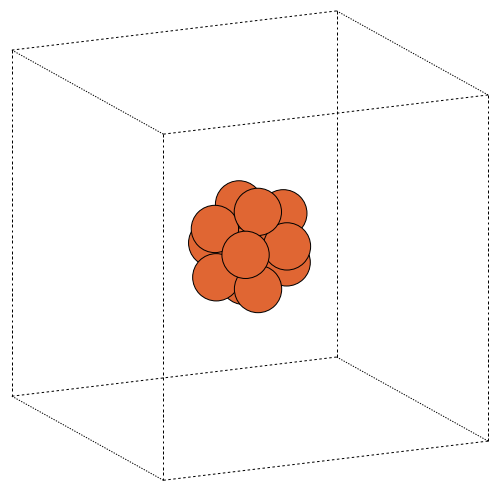

In [4]:
# Elementy sterujące pozwalające wybrać pozycję w sekwencji i temperaturę
n_widget = IntSlider(value=100, min=0, max=1)
T_widget = Dropdown(options=tuple(str(k) for k in sorted(md.keys())),
                    value=str(sorted(md.keys())[0]))

# Zmiana zakresu sekwencji zależnie od wybranej temperatury
def update_n_range(*args):
    n_widget.max = len(md[int(T_widget.value)][1])-1
    
T_widget.observe(update_n_range, 'value')
update_n_range()

# Funkcja wyświetlająca strukturę
def show_cryst(x,y,atom,T,n):
    '''
    Wyświetl strukturę z pozycji n w sekwencji dla temperatury T  
    po obrocie o kąty x, y. Wyświetlane są atomy pierwiastka atom
    lub wszystkie gdy atom='All'
    '''
    # Bufor na grafikę w pamięci
    f=BytesIO()
    if atom == 'All':
        atom=None
    
    # Zapisz obraz do bufora
    ase.io.write(f, recenter(md[int(T)][1][n],atom), show_unit_cell=2, format='png',
                 rotation='%.0fy,%.0fx' % (y,x), scale=30) 
    
    return Image(data=f.getvalue(),format='png')

# Interaktywne wyświetlenie struktury
interact(show_cryst, x=fixed(15), y=fixed(115), atom=('All','Fe','Pt'),
         T=T_widget, n=n_widget);